#Import Library

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from tensorflow import keras

#Preparing Dataset


#CLEANING DATASET

In [ ]:
mentee = pd.read_csv("Mentees.csv")
mentor = pd.read_csv("Mentors.csv")
rating = pd.read_csv("Ratings.csv")

In [ ]:
cols_mente = {"ID MENTEE" : "MenteeID", "SUBJECT" : "Subject" ,"NAME" : "MenteeName", "LOCATION" : "Location"}
mentee.rename(columns=cols_mente, inplace=True)
mentee_df = mentee.loc[0:1499, 'MenteeID' : 'LONGITUDE']

In [ ]:
cols_mentor = {"ID MENTOR" :"TutorID", "NAME" : "TutorName", "LOCATION" : "Location", "MATKUL" : "Subjects"}
mentor.rename(columns=cols_mentor, inplace=True)
temporary = mentor.drop(columns=['SUBJECT'])
mentor_df = temporary.loc[0:499, 'TutorID' : 'LONGITUDE']

In [ ]:
cols_rating = {"ID MENTEE" : "MenteeID", "ID MENTOR" : "TutorID", "RATING" : "Rating"}
rating.rename(columns=cols_rating, inplace=True)
rating_df = rating.loc[0:12625, 'MenteeID' : 'Rating']
rating_df['Rating'] = rating_df['Rating'].astype(np.int64)

In [ ]:
popular_tutor_rating_df = rating_df.merge(mentor_df, on="TutorID")
popular_tutor_rating_df

,MenteeID,TutorID,Rating,TutorName,Subjects,Location,SUBDISTRICT,LATITUDE,LONGITUDE
0,B36652,A16227,3,Andrianto,Ekonomi,Jakarta,JOHAR BARU,-6.183050,106.854320
1,B63077,A16227,5,Andrianto,Ekonomi,Jakarta,JOHAR BARU,-6.183050,106.854320
2,B14364,A16227,5,Andrianto,Ekonomi,Jakarta,JOHAR BARU,-6.183050,106.854320
3,B61521,A16227,4,Andrianto,Ekonomi,Jakarta,JOHAR BARU,-6.183050,106.854320
4,B62409,A16227,5,Andrianto,Ekonomi,Jakarta,JOHAR BARU,-6.183050,106.854320
...,...,...,...,...,...,...,...,...,...
12621,B29822,A17248,3,Junaeri,Matematika,Yogyakarta,PAKUALAMAN,-7.800546,110.375171
12622,B64162,A17248,3,Junaeri,Matematika,Yogyakarta,PAKUALAMAN,-7.800546,110.375171
12623,B32844,A17248,4,Junaeri,Matematika,Yogyakarta,PAKUALAMAN,-7.800546,110.375171
12624,B97893,A17248,5,Junaeri,Matematika,Yogyakarta,PAKUALAMAN,-7.800546,110.375171


#PREPROCESSING DATASET

##Create new dataframe to feed model

In [ ]:
popular_tutor_rating = popular_tutor_rating_df[['MenteeID', 'TutorID', 'Subjects', 'Rating']]
popular_tutor_rating

,MenteeID,TutorID,Subjects,Rating
0,B36652,A16227,Ekonomi,3
1,B63077,A16227,Ekonomi,5
2,B14364,A16227,Ekonomi,5
3,B61521,A16227,Ekonomi,4
4,B62409,A16227,Ekonomi,5
...,...,...,...,...
12621,B29822,A17248,Matematika,3
12622,B64162,A17248,Matematika,3
12623,B32844,A17248,Matematika,4
12624,B97893,A17248,Matematika,5


#COLLABORATIVE FILTERING USING TENSORFLOW

###SPLIT DATASET

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(popular_tutor_rating, test_size=0.2, random_state=42)

###MAP MENTEEID AND TUTORID

In [ ]:
# Get the unique mentee and tutor IDs
mentee_ids = popular_tutor_rating['MenteeID'].unique()

# Create mappings from IDs to indices and vice versa
mentee_to_index = {id: index for index, id in enumerate(mentee_ids)}
index_to_mentee = {index: id for index, id in enumerate(mentee_ids)}

# Get the unique TutorID values
tutor_ids = popular_tutor_rating['TutorID'].unique()

# Create a mapping from TutorID to index
tutor_to_index = {id: index for index, id in enumerate(tutor_ids)}
index_to_tutor = {index: id for index, id in enumerate(tutor_ids)}

###MASKING TRAIN DATA & TEST DATA

In [ ]:
# Masking for training data
df_train = popular_tutor_rating.copy()

for i in range(test_data.shape[0]):
  df_train.loc[(df_train.MenteeID == test_data.iloc[[i]].MenteeID.values[0]) & (df_train.TutorID == test_data.iloc[[i]].TutorID.values[0]), 'Rating'] = 0

In [ ]:
# Making rating 0

df_test = popular_tutor_rating.copy()

for col in df_test.Rating :
  df_test['Rating'].values[:] = 0

In [ ]:
# Masking for testing data

for i in range(test_data.shape[0]):
  df_test.loc[(df_test.MenteeID == test_data.iloc[[i]].MenteeID.values[0]) & (df_test.TutorID == test_data.iloc[[i]].TutorID.values[0]), 'Rating'] = test_data.iloc[[i]].Rating.values[0]

In [ ]:
user_tutor_matrix_train = pd.pivot_table(
    data=df_train,
    values='Rating',
    index='MenteeID',
    columns='TutorID',
    # aggfunc=np.mean,  # Use the mean rating as the aggregation function
    fill_value=0  # Fill missing values with 0
)
user_tutor_matrix_train.shape

(1495, 499)

In [ ]:
user_tutor_matrix_test = pd.pivot_table(
    data=df_test,
    values='Rating',
    index='MenteeID',
    columns='TutorID',
    # aggfunc=np.mean,  # Use the mean rating as the aggregation function
    fill_value=0  # Fill missing values with 0
)
user_tutor_matrix_test

In [ ]:
data_test = pd.pivot_table(
    data=popular_tutor_rating,
    values='Rating',
    index='MenteeID',
    columns='TutorID',
    # aggfunc=np.mean,  # Use the mean rating as the aggregation function
    fill_value=0  # Fill missing values with 0
)
# Generate random ratings for empty values
data_test_filled = data_test.applymap(lambda x: np.random.randint(1, 6) if x == 0 else x)
data_test_filled

##BUILD A MODEL



In [ ]:
class CollaborativeFilteringModel(tf.Module):
    def __init__(self, P, Q):
        super(CollaborativeFilteringModel, self).__init__()
        self.P = tf.Variable(P, name='P')
        self.Q = tf.Variable(Q, name='Q')

    @tf.function(input_signature=[tf.TensorSpec(shape=(None, None), dtype=tf.float32)])
    def predict(self, x):
        # Perform predictions using the learned latent features
        pred_R = tf.matmul(self.P, tf.transpose(self.Q))

        # Calculate the predicted ratings matrix
        predictions = tf.identity(pred_R)

        return {'predictions': predictions}

    def calculate_rmse(self, R, P, Q):
        pred_R = tf.matmul(P, tf.transpose(Q))
        squared_diff = tf.square(R - pred_R)
        mse = tf.reduce_mean(squared_diff)
        rmse = tf.sqrt(mse)
        return rmse

    @tf.function
    def compute_loss(self, R, P, Q, regularization):
        pred_R = tf.matmul(P, tf.transpose(Q))
        cur_loss = tf.reduce_sum(tf.square(R - pred_R))
        regularization_term = tf.reduce_sum(tf.square(P)) + tf.reduce_sum(tf.square(Q))
        cur_loss += regularization * regularization_term
        return cur_loss

    def fit(self, X_train, X_test, num_epochs, learning_rate, regularization):
        X_train = tf.constant(X_train, dtype=tf.float32)
        X_test = tf.constant(X_test, dtype=tf.float32)

        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

        loss_history = []
        rmse_history = []
        test_loss_history = []
        test_rmse_history = []
        @tf.function
        def train_step(R, P, Q):
            with tf.GradientTape() as tape:
                cur_loss = self.compute_loss(R, P, Q, regularization)

            gradients = tape.gradient(cur_loss, [P, Q])
            optimizer.apply_gradients(zip(gradients, [P, Q]))

            return cur_loss

        for epoch in range(num_epochs):
            cur_loss = train_step(X_train, self.P, self.Q)
            loss_history.append(cur_loss.numpy())

            train_rmse = self.calculate_rmse(X_train, self.P, self.Q)
            rmse_history.append(train_rmse.numpy())

            test_loss = self.compute_loss(X_test, self.P, self.Q, regularization)
            test_loss_history.append(test_loss.numpy())

            test_rmse = self.calculate_rmse(X_test, self.P, self.Q)
            test_rmse_history.append(test_rmse.numpy())


            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {cur_loss.numpy()}, Train RMSE: {train_rmse}, Test Loss: {test_loss.numpy()}, Test RMSE: {test_rmse}")

        return loss_history, rmse_history, test_loss_history, test_rmse_history

#MODEL COMPILE

In [ ]:
def build_model(X_train, X_test, num_epochs, learning_rate, regularization, latent_dim):

    num_users, num_items = X_train.shape

    P = tf.Variable(tf.random.normal([num_users, latent_dim]))
    Q = tf.Variable(tf.random.normal([num_items, latent_dim]))

    model = CollaborativeFilteringModel(P, Q)

    loss_history, rmse_history, test_loss_history, test_rmse_history = model.fit(X_train, X_test, num_epochs, learning_rate, regularization)

    return model, loss_history, rmse_history, test_loss_history, test_rmse_history

In [ ]:
# Set the hyperparameters
num_epochs = 300
learning_rate = 0.02
regularization = 0.015
latent_dim = 220

In [ ]:
model, loss_history, rmse_history, test_loss_history, test_rmse_history = build_model(user_tutor_matrix_train, user_tutor_matrix_test, num_epochs, learning_rate, regularization, latent_dim)

##TEST MODEL

In [ ]:
def calculate_mse_rmse(model, X_test):
    pred_R = model.predict(X_test)['predictions']
    actual_R = np.array(X_test, dtype=np.float32)
    mse = tf.reduce_mean(tf.square(actual_R - pred_R))
    rmse = tf.sqrt(mse)
    return mse.numpy(), rmse.numpy()

In [ ]:
mse, rmse = calculate_mse_rmse(model, user_tutor_matrix_train)
mse, rmse

(0.15869673, 0.39836758)

In [ ]:
# Compute the loss on the test data
test_loss = model.compute_loss(tf.cast(user_tutor_matrix_test.values, dtype=tf.float32), model.P, model.Q, regularization)
print(f"Test Loss: {test_loss.numpy()}")

Test Loss: 109280.3359375


#PLOT LOSS AND RMSE

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_and_rmse(train_loss_history, train_rmse_history, test_loss_history, test_rmse_history):
    epochs = len(train_loss_history)
    x = np.arange(1, epochs + 1)

    # Plot train loss
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, train_loss_history, color='Pink')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.title('Train Loss', color='Pink')

    # Plot train RMSE
    plt.subplot(1, 2, 2)
    plt.plot(x, train_rmse_history, color='Pink')
    plt.xlabel('Epoch')
    plt.ylabel('Train RMSE')
    plt.title('Train RMSE', color='Pink')

    # Plot test loss
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, test_loss_history, color='Purple')
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.title('Test Loss', color='Purple')

    # Plot test RMSE
    plt.subplot(1, 2, 2)
    plt.plot(x, test_rmse_history, color='Purple')
    plt.xlabel('Epoch')
    plt.ylabel('Test RMSE')
    plt.title('Test RMSE', color='Purple')

    plt.tight_layout()
    plt.show()

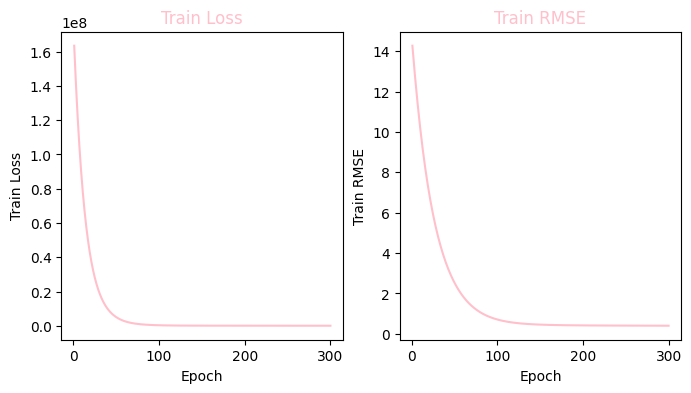

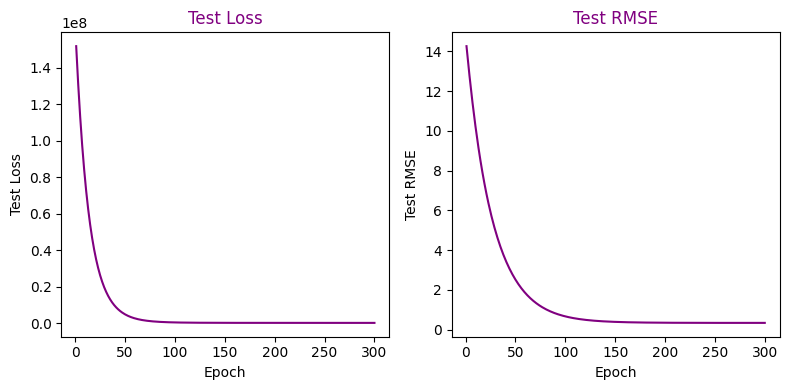

In [ ]:
plot_loss_and_rmse(loss_history, rmse_history, test_loss_history, test_rmse_history)

#Save Model

In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
# Menyimpan model dengan signature
tf.saved_model.save(
    model,
    'collaborative_filtering_model',
    signatures={
        'predict': model.predict.get_concrete_function(
            tf.TensorSpec(shape=(None, None), dtype=tf.float32))
    }
)

##Testing to Make Recommendation

In [ ]:
loaded_model = tf.saved_model.load('collaborative_filtering_model')

In [ ]:
# Generate predictions using the loaded model
test_pred = tf.matmul(loaded_model.P, tf.transpose(loaded_model.Q))

# Convert user_tutor_matrix_test to numpy array
X_test = np.array(user_tutor_matrix_test, dtype=np.float32)
# Calculate the MSE and RMSE for testing
mse = tf.reduce_mean(tf.square(X_test - test_pred))
rmse = tf.sqrt(mse)
print("MSE on loaded model:", mse.numpy())
print("RMSE on loaded model:", rmse.numpy())

MSE on loaded model: 0.117329225
RMSE on loaded model: 0.34253353


In [ ]:
new_predictions = loaded_model.predict(user_tutor_matrix_test)
predictions_array = new_predictions['predictions'].numpy()
predictions_array

array([[ 2.1652460e-01,  6.5354109e-03, -1.8822956e-01, ...,
        -1.4089358e-01,  1.3918471e-01, -6.4182281e-03],
       [ 3.0262882e-01, -2.3150969e-01,  1.2092590e-03, ...,
         3.1113255e-01, -3.5863400e-02,  1.2978750e-01],
       [ 6.6029131e-02, -3.7199259e-02,  2.8655171e-02, ...,
        -4.0038824e-02, -8.1672192e-02, -2.8619766e-03],
       ...,
       [ 2.0679653e-01, -1.8853533e-01,  2.0140970e-01, ...,
         5.6878328e-02,  2.7406120e-01, -4.4265437e-01],
       [ 1.0408735e-01,  6.2641621e-02, -1.0821986e-01, ...,
        -1.7176425e-01, -2.4574280e-01,  1.7390251e-01],
       [ 1.1977782e+00, -1.3760710e-01,  7.1705818e-02, ...,
        -7.6553822e-02,  4.6861172e-04,  8.8102102e-02]], dtype=float32)

In [ ]:
def model_recommend(mentee_id, pred, mentee_to_index, index_to_tutor, top_k=10):
    # Get the index of the specified mentee
    mentee_index = mentee_to_index.get(mentee_id)

    if mentee_index is None:
        print("Mentee ID not found.")
        return []

    # Get the predicted ratings for the specified mentee from the predictions array
    mentee_pred_ratings = pred[mentee_index]

    # Sort the predicted ratings in descending order
    top_indices = np.argsort(mentee_pred_ratings)[::-1][:top_k]

    # Map the indices back to tutor IDs
    top_tutors = [index_to_tutor[i] for i in top_indices]

    return top_tutors

In [ ]:
mentee_id = 'B34255'
# Get the top recommended tutors for the specified mentee
recommended_tutors = model_recommend(mentee_id, predictions_array, mentee_to_index, index_to_tutor, top_k=10)

print("Top recommended tutors for mentee", mentee_id, ":")
for tutor_id in recommended_tutors:
    print(tutor_id)

Top recommended tutors for mentee B34255 :
A59644
A51472
A58378
A85530
A28425
A75116
A85449
A66207
A87636
A28116


##To Make Sure the model give good enough recommendation

In [ ]:
popular_tutor_rating.loc[popular_tutor_rating['MenteeID']=='B34255']

,MenteeID,TutorID,Subjects,Rating
8425,B34255,A70862,Kimia,5
8507,B34255,A61005,Bahasa Inggris,3
8563,B34255,A20245,Kimia,3
8615,B34255,A57923,Ekonomi,3
8859,B34255,A94552,Sejarah,5
8919,B34255,A12059,Kimia,4
9123,B34255,A72629,Ekonomi,5
9204,B34255,A76751,Ekonomi,4
9377,B34255,A91673,Kimia,5


In [ ]:
popular_tutor_rating.loc[popular_tutor_rating['TutorID']=='A28116']

,MenteeID,TutorID,Subjects,Rating
11871,B70293,A28116,Fisika,3
11872,B93232,A28116,Fisika,5
11873,B18208,A28116,Fisika,5
11874,B57152,A28116,Fisika,3
11875,B51049,A28116,Fisika,4
11876,B76136,A28116,Fisika,3
11877,B97242,A28116,Fisika,3
11878,B81633,A28116,Fisika,5
11879,B68871,A28116,Fisika,4
11880,B57577,A28116,Fisika,3


#TF LITE DEPLOY

In [ ]:
# Load the saved model
model = tf.saved_model.load('collaborative_filtering_model')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('collaborative_filtering_model')
tflite_model = converter.convert()

# Save the TFLite model
with open('CF_Model.tflite', 'wb') as f:
    f.write(tflite_model)